# Sorting and normalizing metadata

From June through September, 2020, we manually checked genre for about a thousand volumes identified as English-language fiction and biography. But the genres were often misidentified by the algorithmic process that selected these titles, so bio and fic ended up jumbled together in the same files.

This Jupyter notebook assembles that data and sorts it into separate data frames for fiction and biography. It also "normalizes" the metadata. Human coders may use many slightly different versions of the same label, but when the data is ultimately used by an algorithm, we're going to need those labels to all be exactly the same.

In [1]:
import pandas as pd
import os, glob
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
sourcefiles = glob.glob('fictionmeta/*.tsv')
sourcefiles

['fictionmeta/supplementary_peizhen_fic.tsv',
 'fictionmeta/peizhenfic_summer.tsv',
 'fictionmeta/current_wenyi_fic.tsv',
 'fictionmeta/current_morgan_fic.tsv',
 'fictionmeta/allmatchedbiographies.tsv',
 'fictionmeta/current_ted_fic.tsv']

### Sort the rows

We go through each file, identify it as bio or fic, and correct a few details.

In [18]:
multiplectr = 0
noctr = 0

biorows = []
ficrows = []
weirdos = []
norows = []

weird_audiences = set()

for filename in sourcefiles:
    data = pd.read_csv(filename, sep = '\t')
    for idx, row in data.iterrows():
        
        # let's add a column for coder in case we need it later
        
        if 'peizhen' in filename:
            row['coder'] = 'peizhen'
        elif 'wenyi' in filename:
            row['coder'] = 'wenyi'
        elif 'morgan' in filename:
            row['coder'] = 'morgan'
        elif 'biographies' in filename:
            row['coder'] = 'morgan'  # most likely
        elif 'ted' in filename:
            row['coder'] = 'ted'
        
        # The next few lines standardize our treatment of vols
        # where there are multiple Hathi IDs aligned with a single
        # Gutenberg ID. In that situation, we're going to have
        # 'y' in the multiplehtids column, and the IDs themselves,
        # in order and separated by pipes, in the docid column.
        
        if '|' in row['docid']:
            print("multiple field: ", row['multiplehtids'])
            row['multiplehtids'] = 'y'
            multiplectr += 1
        elif not pd.isnull(row['multiplehtids']) and '|' in row['multiplehtids']:
            row['docid'] = row['multiplehtids']
            row['multiplehtids'] = 'y'
            print(row['docid'])
            multiplectr += 1
    
        # the audience field should either contain nothing,
        # or the tag 'juv.' There are lots of other things in there in
        # practice, but I'm going to assume they are all equivalent to
        # 'juv'. To ensure I'm not making a mistake, I'll print them
        
        if 'audience' not in row:
            row['audience'] = float('nan')
            
        if (not pd.isnull(row['audience'])) and (not row['audience'] == 'juv'):
            weird_audiences.add(row['audience'])
            row['audience'] = 'juv'
                  
        # the following rows just sort bio from fic
        # they assume that the genre string will begin with
        # either 'bio' or 'fic' (or 'no')
        # some special else-if statements deal with
        # exceptions and normalize them
        
        genre = row['genre']
        if pd.isnull(genre):
            continue
        elif genre.startswith('no'):
            noctr += 1
            norows.append(row)
        elif genre.startswith('bio'):
            biorows.append(row)
        elif genre.startswith('fic'):
            ficrows.append(row)
        elif genre == 'historical fic':
            row['genre'] = 'fic|historical'
            ficrows.append(row)
        elif genre == 'romance':
            row['genre'] = 'fic|romance'
            ficrows.append(row)
        elif genre == 'adventure fic':
            row['genre'] = 'fic'
            ficrows.append(row)
        else:
            # what even is this?
            weirdos.append(genre)
            print(filename)

biodf = pd.DataFrame(biorows)
ficdf = pd.DataFrame(ficrows)
nodf = pd.DataFrame(norows)
            
print(multiplectr)           

multiple field:  y
multiple field:  nan
multiple field:  nan
multiple field:  nan
multiple field:  nan
njp.32101066714179|njp.32101066714187|njp.32101066714195
6


In [4]:
weird_audiences

{'Juvenile audience', 'children', 'juvenile', 'young adults'}

Yes we were right to assume that all weird strings in the audience field should be 'juv.'

In [5]:
biodf.shape

(131, 22)

In [6]:
ficdf.shape

(564, 22)

### Investigating genre

Let's peer into those genre categories a little deeper and normalize them

In [7]:
fiction_genres = ficdf['genre']

genrectr = Counter()

for genre in fiction_genres:
    gparts = set(genre.split('|'))
    for g in gparts:
        g = g.strip()
        genrectr[g] += 1

print()
print("COMMON GENRES:")
for g, count in genrectr.most_common():
    print(g, count)
    


COMMON GENRES:
fic 564
historical 95
short 57
romance 34
domestic 33
mystery 30
adventure 20
folklore 19
travel 17
western 6
historical fic 6
children 5
fantasy 5
juvenile 5
historical fiction 4
detective 4
social 3
female 2
religious 2
Short stories 2
Fairy tales 2
social life 2
sf 2
war 1
narratives 1
historical novel 1
science fiction 1
gothic 1
poetry 1
nature 1
narrative 1
music 1
realistic 1
myth 1
international 1
decadant 1


The only genres we officially planned to code were mystery, sf (science fiction), romance, short, folklore, and historical. Let's normalize to those. Other categories are too small to be useful for our present purposes.


In [8]:
official = {'mystery', 'historical', 'short', 'romance', 'mystery', 'folklore', 'sf'}
ficdf = ficdf.reset_index()
ficdf = ficdf.drop(axis = 1, labels = 'index')

for idx in ficdf.index:
    genre = ficdf.at[idx, 'genre']
    gparts = [x.strip() for x in genre.split('|')]
    officialgenres = set()
    for g in gparts:
        if g in official:
            officialgenres.add(g)
        elif g == 'science fiction':
            officialgenres.add('sf')
        elif g == 'historical fic':
            officialgenres.add('historical')
        elif g == 'historical novel':
            officialgenres.add('historical')
        elif g == 'Short stories':
            officialgenres.add('short')
        elif g == 'historical fiction':
            officialgenres.add('historical')
        elif g == 'detective':
            officialgenres.add('mystery')
        elif g == 'juvenile':
            ficdf.at[idx, 'audience'] = 'juv'
        elif g == 'children':
            ficdf.at[idx, 'audience'] = 'juv'
        else:
            pass  # we don't add genres that aren't in this list
        
    if len(officialgenres) > 0:
        normalizedgenrestring = 'fic | ' + ' | '.join(officialgenres)
    else:
        normalizedgenrestring = 'fic'
    
    ficdf.at[idx, 'genre'] = normalizedgenrestring
    

In [9]:
ficdf = ficdf.sort_values(by = 'latestcomp')

In [13]:
ficdf.to_csv('annotatednormalizedfictionmeta.tsv', sep = '\t', index = False)

In [11]:
biodf = biodf.sort_values(by = 'latestcomp')

In [14]:
biodf.to_csv('annotatednormalizedbiometa.tsv', sep = '\t', index = False)

### How many books for young readers do we have?

In [15]:
sum(ficdf['audience'] == 'juv')

101

### What's the approximate distribution across the timeline?

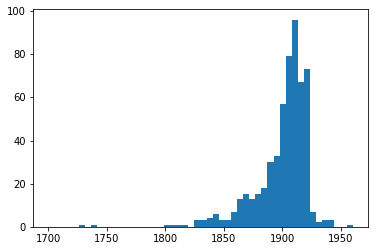

In [16]:
plt.hist(ficdf['latestcomp'], bins = 50, range = (1700, 1960))
plt.show()

Unfortunately we don't have enough before 1820; we'll probably need to do a manual dive to find works of fiction in Hathi before 1820 that have Gutenberg (or ECCO) clean text versions.

In [17]:
fiction_genres = ficdf['genre']

genrectr = Counter()

for genre in fiction_genres:
    gparts = set(genre.split('|'))
    for g in gparts:
        g = g.strip()
        genrectr[g] += 1

print()
print("COMMON GENRES:")
for g, count in genrectr.most_common():
    print(g, count)


COMMON GENRES:
fic 564
historical 106
short 59
mystery 34
romance 34
folklore 19
sf 3


### checking duplicates

In [16]:
df = pd.read_csv('fictionmeta/peizhenfic_summer.tsv', sep = '\t')
dups = df.pivot_table(index = ['gbindex'], aggfunc ='size') 

In [17]:
dups = dups.sort_values(ascending = False)

In [18]:
dups[0:40]

gbindex
28346    3
59236    1
35997    1
37243    1
37180    1
37118    1
37046    1
37029    1
36953    1
36914    1
36758    1
36626    1
36612    1
36602    1
36414    1
36160    1
35805    1
37415    1
35717    1
35507    1
35500    1
35119    1
34996    1
34939    1
34883    1
34852    1
34830    1
34811    1
34801    1
34297    1
37250    1
37453    1
34009    1
37627    1
41256    1
41182    1
40893    1
40874    1
40735    1
40726    1
dtype: int64

In [19]:
nodf.to_csv('titles_rejected.tsv', sep = '\t', index = False)